In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy import odr
import seaborn as sns
import scipy.signal as sig
from astropy.table import Table
from astropy.io import ascii
import os

sns.set_context('poster')
sns.set_style("ticks")
sns.set_palette("colorblind")

def sim_exp(exp_min=30000, exp_max=150000, step = 10000, n=50):
    cwd = os.getcwd()
    filepath = '/Volumes/LaCie/AstroData/Circinus_ULX5/xmm/0792382701/products/'
    os.chdir(filepath)
    exposures = np.arange(exp_min, exp_max, step=step)
#     T_err = [[] for i in range(len(exposures))]
    Gamma_err = [[] for i in range(len(exposures))]
    mos1_rate = [[] for i in range(len(exposures))]
    mos1_err = [[] for i in range(len(exposures))]
    mos2_rate = [[] for i in range(len(exposures))]
    mos2_err = [[] for i in range(len(exposures))]
    pn_rate = [[] for i in range(len(exposures))]
    pn_err = [[] for i in range(len(exposures))]
    mos1_frac = [[] for i in range(len(exposures))]
    mos2_frac = [[] for i in range(len(exposures))]
    pn_frac = [[] for i in range(len(exposures))]
    for i, exp in enumerate(exposures):
        print(i)
        for j in range(n):
#             tmp = open('sim_files/sim_in.txt', 'w')
#             tmp.close()
#             with open('sim_files/sim_in.txt', 'a') as xspec_file:
#                 xspec_file.write('@xmm_template.xcm' + ' \n')
#                 xspec_file.write('fakeit nowrite' + ' \n')
#                 xspec_file.write('y' + ' \n')
#                 xspec_file.write('sim_' + ' \n')
#                 xspec_file.write('sim_mos1_src.fak' + ' \n')
#                 xspec_file.write(str(exp) + ', 1.0, ' + str(exp) + ' \n')
#                 xspec_file.write('sim_mos2_src.fak' + ' \n')
#                 xspec_file.write(str(exp) + ', 1.0, ' + str(exp) + ' \n')
#                 xspec_file.write('sim_pn_src.fak' + ' \n')
#                 xspec_file.write(str(exp) + ', 1.0, ' + str(exp) + ' \n')
#                 xspec_file.write('ignore bad' + ' \n')
#                 xspec_file.write('ignore **:**-0.3,10.-**' + ' \n')
#                 xspec_file.write('statistic cstat' + ' \n')
#                 xspec_file.write('fit' + ' \n')
#                 xspec_file.write('show all' + ' \n')
#                 xspec_file.write('err 3' + ' \n')
#                 xspec_file.write('exit' + ' \n')
#             os.system('xspec < sim_files/sim_in.txt >& sim_files/sim_exp'+str(i)+'_'+str(j)+'_out.txt')
#             os.system('rm *.fak')
            with open(filepath + 'sim_files/sim_exp'+str(i)+'_'+str(j)+'_out.txt', 'r') as outfile:
#                 temp_T = None
                temp_Gamma = None
                temp_mos1 = None
                temp_mos2 = None
                temp_pn = None
                for line in outfile:
#                     if (' 3    3   simpl      Gamma' in line):
                    if ('(-' in line) and ('     3      ' in line) and (')' in line):
                        temp_Gamma = line.split()[-1]
#                     elif (' 9    5   diskbb     Tin' in line):
#                         temp_T = line.split()[-1]
                    elif ('Net count rate (cts/s) for Spectrum:1') in line:
                        temp_mos1 = line.split()
                    elif ('Net count rate (cts/s) for Spectrum:2') in line:
                        temp_mos2 = line.split()
                    elif ('Net count rate (cts/s) for Spectrum:3') in line:
                        temp_pn = line.split()

                Gamma_err[i].append((float(temp_Gamma.split(',')[0][1:]), \
                                     float(temp_Gamma.split(',')[1][:-1])))
                mos1_rate[i].append(float(temp_mos1[6]))
                mos1_err[i].append(float(temp_mos1[8]))
                mos1_frac[i].append(float(temp_mos1[9][1:])/100)
                mos2_rate[i].append(float(temp_mos2[6]))
                mos2_err[i].append(float(temp_mos2[8]))
                mos2_frac[i].append(float(temp_mos2[9][1:])/100)
                pn_rate[i].append(float(temp_pn[6]))
                pn_err[i].append(float(temp_pn[8]))
                pn_frac[i].append(float(temp_pn[9][1:])/100)
    os.chdir(cwd)
    return np.array(exposures), np.array(Gamma_err), np.array(mos1_rate), np.array(mos1_err), \
        np.array(mos2_rate), np.array(mos2_err), np.array(pn_rate), np.array(pn_err), \
        np.array(mos1_frac), np.array(mos2_frac), np.array(pn_frac)



In [2]:
exposures, Gamma_err, mos1_rate, mos1_err, mos2_rate, mos2_err, pn_rate, pn_err, mos1_frac, mos2_frac, pn_frac = sim_exp()



0
1
2
3
4
5
6
7
8
9
10
11


105.45198498962426
74.71269561574748
52.6934985417522


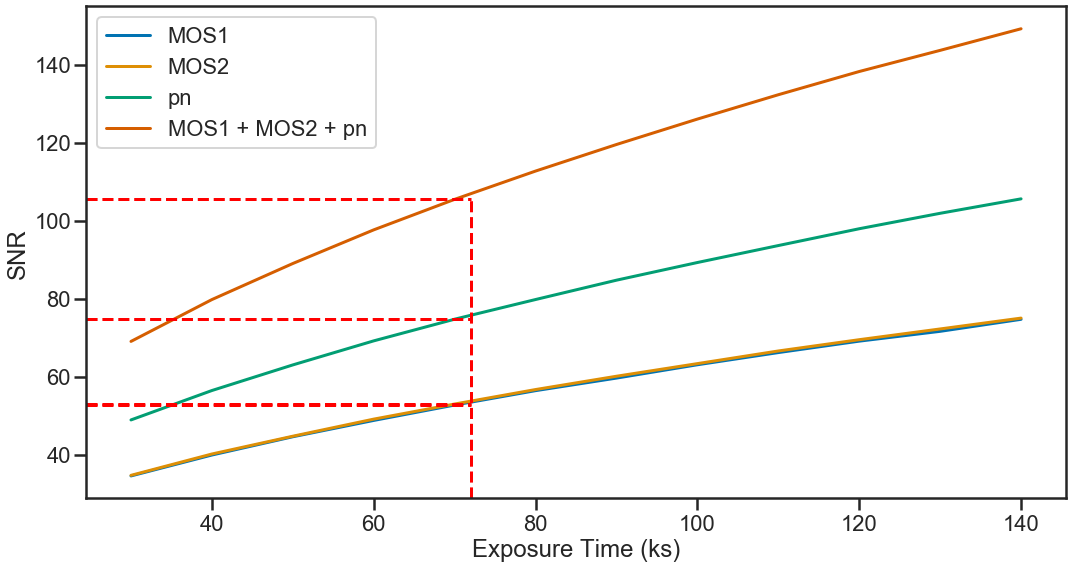

In [7]:
mos1_snr = []
mos2_snr = []
pn_snr = []
total_snr = []
proposed_t = 72
for i, t in enumerate(exposures):
    mos1_snr.append(np.mean(np.sqrt(mos1_frac[i]*mos1_rate[i]*t)))
    mos2_snr.append(np.mean(np.sqrt(mos2_frac[i]*mos2_rate[i]*t)))
    pn_snr.append(np.mean(np.sqrt(pn_frac[i]*pn_rate[i]*t)))
    total_snr.append(np.mean((mos1_rate[i] + mos2_rate[i] + pn_rate[i])*np.sqrt(t/((mos1_rate[i]/mos1_frac[i]) \
                                        + (mos2_rate[i]/mos2_frac[i]) + (pn_rate[i]/pn_frac[i])))))
    
plt.figure(figsize=(15,8))
plt.plot(exposures/1000, mos1_snr, label = 'MOS1')
plt.plot(exposures/1000, mos2_snr, label = 'MOS2')
plt.plot(exposures/1000, pn_snr, label = 'pn')
plt.plot(exposures/1000, total_snr, label = 'MOS1 + MOS2 + pn')
plt.axvline(proposed_t, ymax = (total_snr[np.argmin(np.abs((exposures/1000)-proposed_t))]-plt.ylim()[0])/(plt.ylim()[1]-plt.ylim()[0]), \
            ls='--', color='red')
plt.axhline(total_snr[np.argmin(np.abs((exposures/1000)-proposed_t))], xmax = (proposed_t-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0]), \
            ls='--', color='red')
plt.axhline(pn_snr[np.argmin(np.abs((exposures/1000)-proposed_t))], xmax = (proposed_t-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0]), \
            ls='--', color='red')
plt.axhline(mos1_snr[np.argmin(np.abs((exposures/1000)-proposed_t))], xmax = (proposed_t-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0]), \
            ls='--', color='red')
plt.axhline(mos2_snr[np.argmin(np.abs((exposures/1000)-proposed_t))], xmax = (proposed_t-plt.xlim()[0])/(plt.xlim()[1]-plt.xlim()[0]), \
            ls='--', color='red')

plt.legend()
plt.xlabel('Exposure Time (ks)')
plt.ylabel('SNR')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('/Users/sean/Desktop/CircinusULX5/SNR_plot.pdf')

print(total_snr[np.argmin(np.abs((exposures/1000)-proposed_t))])
print(pn_snr[np.argmin(np.abs((exposures/1000)-proposed_t))])
print(mos1_snr[np.argmin(np.abs((exposures/1000)-proposed_t))])




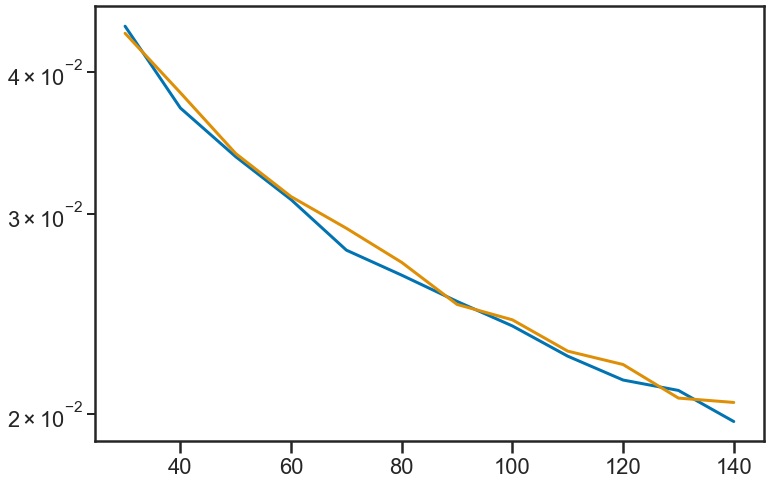

In [5]:
plt.figure(figsize=(12,8))
plt.plot(exposures/1000, [-np.mean(Gamma_err[i].T[0]) for i in range(len(exposures))])
plt.plot(exposures/1000, [np.mean(Gamma_err[i].T[1]) for i in range(len(exposures))])
plt.yscale('log')

In [5]:
mos1_rate

array([[0.04289, 0.04262, 0.04184, 0.04287, 0.04068, 0.04398, 0.04229,
        0.0434 , 0.04136, 0.04361, 0.04364, 0.04322, 0.04163, 0.04375,
        0.04532, 0.04235, 0.04284, 0.04316, 0.04258, 0.04334, 0.0412 ,
        0.04246, 0.04131, 0.04431, 0.04346, 0.04373, 0.04172, 0.04231,
        0.04251, 0.04269, 0.0409 , 0.04372, 0.04252, 0.04425, 0.04177,
        0.04111, 0.04144, 0.0417 , 0.04328, 0.04172, 0.04556, 0.04224,
        0.04278, 0.04382, 0.04077, 0.04095, 0.0432 , 0.0428 , 0.04142,
        0.0415 ],
       [0.04352, 0.04361, 0.04228, 0.04197, 0.04152, 0.04143, 0.04347,
        0.0428 , 0.04138, 0.04333, 0.0422 , 0.04324, 0.04481, 0.04231,
        0.04246, 0.04224, 0.04233, 0.04334, 0.04186, 0.04277, 0.04169,
        0.04163, 0.0434 , 0.04226, 0.04253, 0.0443 , 0.04293, 0.04187,
        0.04223, 0.04297, 0.0445 , 0.04172, 0.04304, 0.0425 , 0.04371,
        0.04371, 0.04478, 0.04241, 0.04252, 0.04212, 0.04172, 0.04139,
        0.04352, 0.04339, 0.04269, 0.04455, 0.04102, 0.0433

In [6]:
pn_rate

array([[0.09697, 0.09649, 0.09691, 0.09558, 0.09323, 0.09533, 0.09555,
        0.09563, 0.09691, 0.09815, 0.09492, 0.1009 , 0.09665, 0.09421,
        0.09566, 0.09832, 0.09648, 0.09275, 0.09919, 0.1011 , 0.09497,
        0.09663, 0.0961 , 0.09545, 0.0945 , 0.1006 , 0.09393, 0.09566,
        0.09247, 0.09478, 0.0984 , 0.09423, 0.09264, 0.09824, 0.09823,
        0.09393, 0.09588, 0.0972 , 0.09626, 0.09446, 0.09473, 0.1009 ,
        0.09233, 0.09638, 0.09695, 0.09569, 0.09909, 0.09465, 0.09889,
        0.09896],
       [0.09518, 0.09669, 0.09855, 0.09497, 0.09509, 0.09745, 0.09454,
        0.09441, 0.09735, 0.09702, 0.09701, 0.09519, 0.09463, 0.09593,
        0.0969 , 0.09459, 0.09531, 0.09258, 0.09634, 0.09935, 0.09631,
        0.09265, 0.09813, 0.09463, 0.09608, 0.09424, 0.09757, 0.09914,
        0.09699, 0.09533, 0.09632, 0.09225, 0.09583, 0.09691, 0.09679,
        0.09832, 0.09931, 0.099  , 0.0993 , 0.09437, 0.09727, 0.09493,
        0.0983 , 0.09625, 0.09492, 0.09589, 0.09602, 0.0945